In [20]:
! pip install split-folders

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [23]:
transform = transforms.Compose([transforms.ToTensor()])

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Dropout Regularization and Batch Normalization

/content/drive/MyDrive/Course Material/Supervised Machine Learning/Dropout Regularization and Batch Normalization


# Split the folder into train and test and Prepare train and test datasets, Loaders


In [27]:
splitfolders.ratio("Circle_Cross", output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 2001 files [00:17, 113.26 files/s]


In [28]:
train_data = datasets.ImageFolder('output/train', transform = transform)
test_data = datasets.ImageFolder('output/val', transform = transform)

In [29]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['circles', 'crosses']
Training images available: 1599
Testing images available:  401


## Display a batch of images

In [30]:
for images,labels in train_loader:
    break
images.shape



torch.Size([32, 3, 116, 116])

In [31]:
labels

tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1])

Label: [1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1]
Class: crosses crosses crosses circles crosses circles circles crosses circles crosses crosses crosses crosses circles crosses crosses circles crosses circles circles crosses crosses circles circles circles circles crosses crosses circles circles crosses crosses


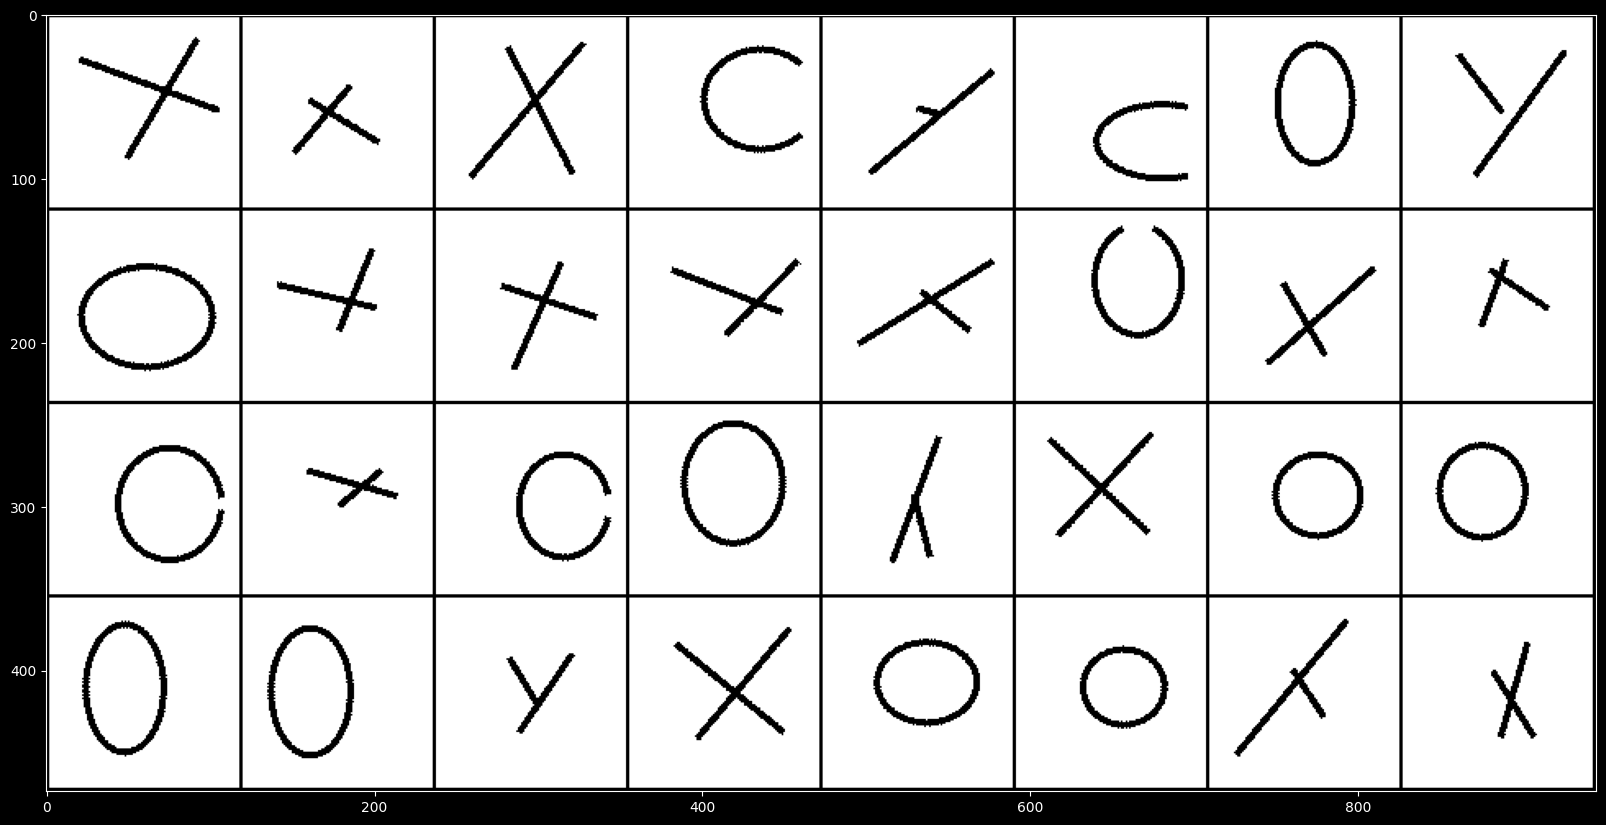

In [32]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images)


# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Create Neural Network Without Dropout

In [33]:
model = nn.Sequential(
          nn.Linear(40368,2048),  # 3 x 116 x 116 = 40368
          nn.ReLU(),
          nn.Linear(2048,2048),
          nn.ReLU(),
          nn.Linear(2048,1024),
          nn.ReLU(),
          nn.Linear(1024,512),
          nn.ReLU(),
          nn.Linear(512,256),
          nn.ReLU(),
          nn.Linear(256,128),
          nn.ReLU(),
          nn.Linear(128,64),
          nn.ReLU(),
          nn.Linear(64,2),
          )
model

Sequential(
  (0): Linear(in_features=40368, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=2, bias=True)
)

## Train and Test the model

In [ ]:
epochs = 41
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),momentum = 0.9, lr = 0.001)

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


  # loop over epochs
for epoch in range(epochs):

    model.train()
    model.to(device)
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      X = X.reshape(32,40368) # Reshaping 4D to 2D
      X = X.to(device)
      y = y.to(device)

      ypred =  model(X)
      loss = lossfun(ypred,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      ypred = ypred.cpu()
      y = y.cpu()

      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      batchAcc.append(acc)

    trainAcc.append( np.mean(batchAcc) )

    losses[epoch] = np.mean(batchLoss)

    # TESTING


    model.eval()
    with torch.no_grad():

        for X,y in test_loader:
            X = X.reshape(32,40368)
            X = X.to(device)
            y = y.to(device)


            ypred =  model(X)
            ypred = ypred.cpu()
            y = y.cpu()

    testAcc.append( 100*torch.mean((torch.argmax(ypred,axis=1)==y).float()) )
    if (epoch % 5) == 0:
      print(f'epoch: {epoch}   loss: {loss.item()}')




epoch: 0   loss: 0.6911655068397522
epoch: 5   loss: 0.6912563443183899
epoch: 10   loss: 0.6930051445960999
epoch: 15   loss: 0.6907712817192078
epoch: 20   loss: 0.6887468695640564
epoch: 25   loss: 0.6819268465042114
epoch: 30   loss: 0.6473415493965149
epoch: 35   loss: 0.5741918087005615
epoch: 40   loss: 0.09826520085334778


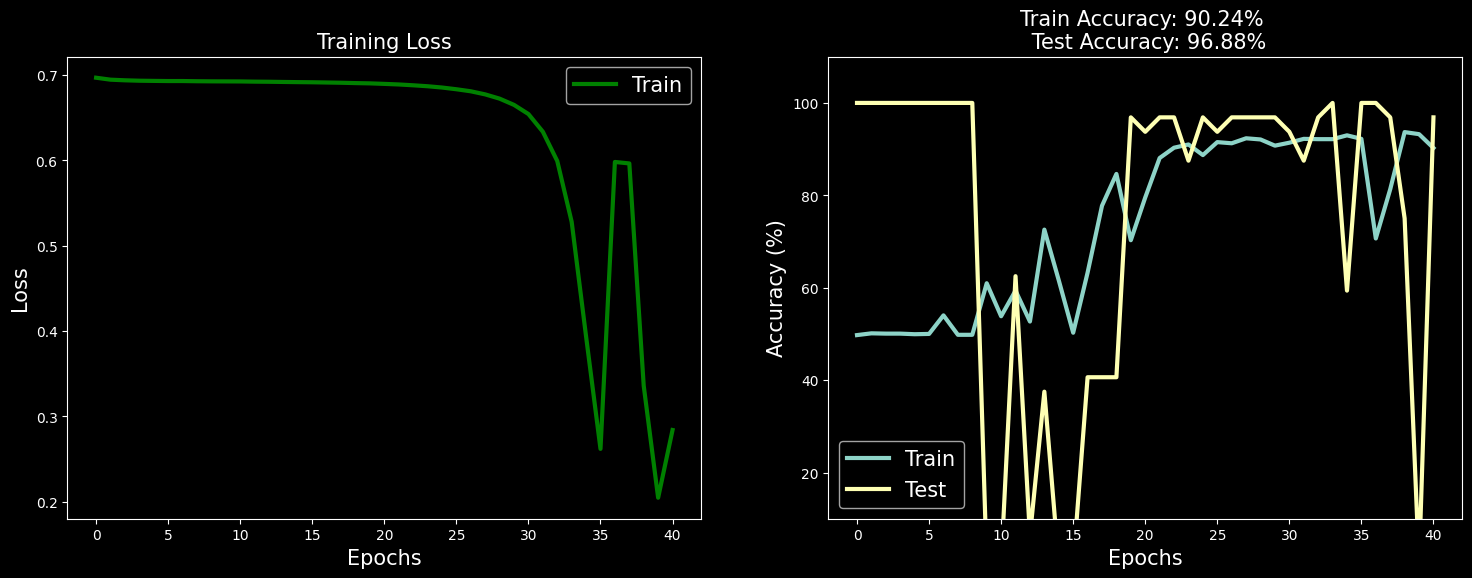

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

# Create Neural Network With Dropout Regularization

In [34]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(40368, 2048)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2048, 2048)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(0.2)
        self.fc4 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc5 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc6 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(64, 2)

    def forward(self,x):

    # Pass the data through the input layer

        x = self.input(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.dropout(x)

        # output layer

        x = self.output(x)
        # X = torch.sigmoid
        return x

In [ ]:
model2 = Classifier()

In [ ]:
epochs = 41
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(),momentum = 0.9, lr = 0.001)

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


  # loop over epochs
for epoch in range(epochs):

    model2.train()
    model2.to(device)
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      X = X.reshape(32,40368) # Reshaping 4D to 2D
      X = X.to(device)
      y = y.to(device)

      ypred =  model2(X)
      loss = lossfun(ypred,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      ypred = ypred.cpu()
      y = y.cpu()

      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      batchAcc.append(acc)

    trainAcc.append( np.mean(batchAcc) )

    losses[epoch] = np.mean(batchLoss)

    # TESTING


    model2.eval() # eval() deactivates dropout during testing.
    with torch.no_grad():

        for X,y in test_loader:
            X = X.reshape(32,40368)
            X = X.to(device)
            y = y.to(device)


            ypred =  model2(X)
            ypred = ypred.cpu()
            y = y.cpu()

    testAcc.append( 100*torch.mean((torch.argmax(ypred,axis=1)==y).float()) )
    if (epoch % 5) == 0:
      print(f'epoch: {epoch}   loss: {loss.item()}')




epoch: 0   loss: 0.6944203972816467
epoch: 5   loss: 0.6942729949951172
epoch: 10   loss: 0.6937131881713867
epoch: 15   loss: 0.6930996775627136
epoch: 20   loss: 0.6931168437004089
epoch: 25   loss: 0.6893163323402405
epoch: 30   loss: 0.6893460750579834
epoch: 35   loss: 0.6835925579071045
epoch: 40   loss: 0.6481601595878601


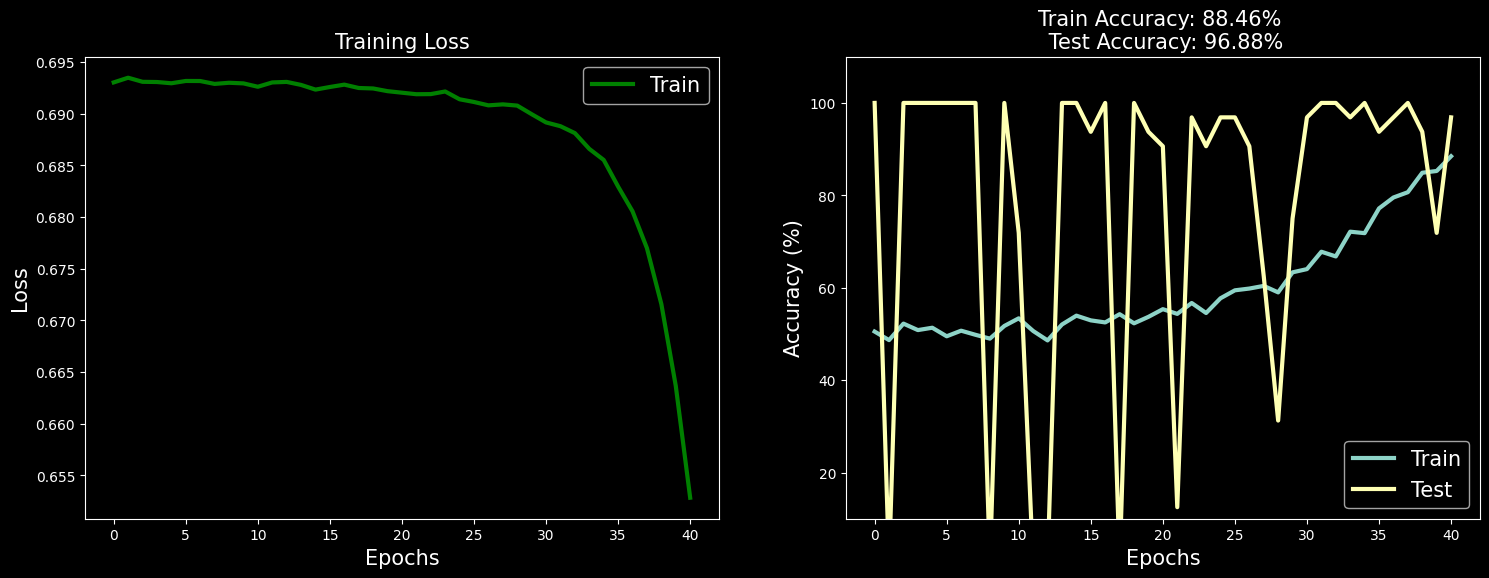

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()